In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

# 1. Introduction

In this first practical session we will make the first contact with the featuring engineering process and its impact in a ML pipeline.
Feature engineering is one of the most important step of the process of developing prediction models. It is considered, by many authors, an art, and it involves human-driven design and intuition. This practice will try to uncover the most relevant issues that must be addressed, and also provide some guidelines to start building sound feature engineering processes for ML problems. 

The experimental dataset we are going to use is the HR Analytics Dataset. It includes explanatory variables of around 15k employees of a large company. The goal of the case study is to
model the probability of attrition (employees leaving, either on their own or because they got fired) of each employee, as well as to understand which variables are the most important ones and need to be addressed right away.

The results obtained will be helpful for the management in order to understand what changes they should make to their workplace to get most of their employees to stay.

For more details on the dataset and the task see: <https://www.kaggle.com/manojvijayan/feature-engineering-for-logistic-regression>.

# 2. Data Loading and initial analysis

Let's load the dataset to make sense of the information we have about the employees.

In [2]:
initial_hr_df = pd.read_csv("turnover.csv")
initial_hr_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [3]:
initial_hr_df.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
# Keep the original dataset for later comparisons and make a copy for the FE process
hr_df = initial_hr_df.copy()

We have 10 columns: 
* the target variable (`left`)
* 9 more features to work with

In [5]:
initial_hr_df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

# 3. Initial prediction and analysis: baseline

Let's see the results and the evaluation of using the data as it is. We will predict `target` using the data available.

Our estimator is gonna be `scikit-learn`'s `LogisticRegression`.

We'll split our data into 2 parts: 66 % for training and 33 % for testing

### 3.1. Train-Test Splitting

We are going to split the initial dataset in training and test for the later evaluation of our ML models. To that end, sklearn again provides a `train_test_split` function to do it.

The ratio of `test` data to total is 33 %.

The split between `train` and `test` is done randomly, but in order for all of us to receive the same random split we have to set the `random_state` parameter.

In [6]:
from sklearn.model_selection import train_test_split

# left is the target variable
X = initial_hr_df.drop(["sales", "salary", "left"], axis=1) 
# not using categorical variables since LogisticRegression can't deal with them
y = initial_hr_df['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### 3.2. Training the `baseline` model

In [7]:
from sklearn import linear_model
baseline_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
baseline_lm_mod.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='none')

### 3.3. Feature importance

Sklearn does not provide a handy way to plot the feature importance of the LogisticRegression models. We can work it out by extracting the values of the logreg coefficients. (Code taken from: https://stackoverflow.com/a/47191103)

We will establish the importance of each feature according to the coefficient.

This coefficient represents the `alpha` that is multiplying each feature (`x_i`) in the optimization part when training the Logisitc Regression.

In [8]:
def get_feature_importance(clf, feature_names):
    feature_importance =  (
        pd.DataFrame(
            {
                'variable': feature_names, # Feature names
                'coefficient': clf.coef_[0] # Feature Coeficients
            }
        )
        .round(decimals=2) \
        .sort_values('coefficient', ascending=False) \
        .style.bar(color=['red', 'green'], align='zero')
    )
    return feature_importance

In [9]:
get_feature_importance(baseline_lm_mod, X_train.columns)

,variable,coefficient
1,last_evaluation,0.720000
4,time_spend_company,0.230000
3,average_montly_hours,0.000000
2,number_project,-0.290000
5,Work_accident,-1.430000
6,promotion_last_5years,-1.720000
0,satisfaction_level,-4.210000


### 3.4. Prediction and evaluation metrics

In [10]:
y_hat_baseline = baseline_lm_mod.predict(X_test)

In [11]:
from sklearn.metrics import (
    confusion_matrix,
    plot_confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    auc,
    cohen_kappa_score,
    matthews_corrcoef
)

def evaluation_metrics(y_true, y_hat, name):
    eval_dict = {}
    eval_dict["name"] = name
    eval_dict["accuracy"] = accuracy_score(y_true, y_hat)
    eval_dict["precision"] = precision_score(y_true, y_hat, labels=y_test.unique())
    eval_dict["recall"] = recall_score(y_true, y_hat, labels=y_test.unique())
    eval_dict["f1"] = f1_score(y_true, y_hat, labels=y_test.unique())
    eval_dict["cohen_kappa"] = cohen_kappa_score(y_true, y_hat, labels=y_test.unique())
    eval_dict["MCC"] = matthews_corrcoef(y_true, y_hat)
    return eval_dict

Labels: [1, 0]


,name,accuracy,precision,recall,f1,cohen_kappa,MCC
0,baseline,0.757374,0.482935,0.239627,0.320317,0.192538,0.21008


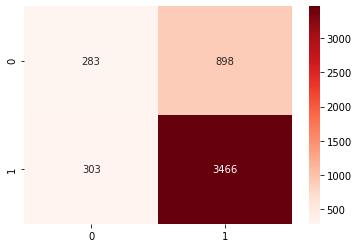

In [12]:
# let's see the labels we are predicting
labels = list(hr_df["left"].unique())
print(f"Labels: {labels}")

# evaluation metrics
results = {}
baseline_metrics = evaluation_metrics(y_test, y_hat_baseline, "baseline")
results["baseline"] = baseline_metrics

# confusion matrix
conf_mtx = confusion_matrix(y_test, y_hat_baseline, labels=labels)
sns.heatmap(conf_mtx, annot=True, cmap="Reds", fmt="d")

# print metrics
pd.DataFrame(results.values())

The model as it is has good accuracy, but the rest of the metrics seem to be not so good.
* `precision = tp / (tp + fp)`: more false positives than true positives
* `recall = tp / (tp + fn)`: false negatives are higher than true positives, dragging down the score

# 4. Feature engineering

We start our Feature Engineering tasks by working on the copy we did of the `initial_hr_df`: `hr_df`

In [13]:
hr_df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

In [14]:
hr_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# 4.1 Factorize Features

2 of the categories (`sales` and `salary`) are categorical. In addition, if we analyze the rest of the features we will see that we have three more categorical values encoded as numeric:

* `Work_accident`
* `promotion_last_5years`
* target variable itself (`left`). 

Therefore, we should convert them to categorical before any further processing. You can use the `astype` method for the conversion.

In [15]:
hr_df['sales'] = hr_df["sales"].astype('category')
hr_df['salary'] = hr_df["salary"].astype('category')
hr_df['promotion_last_5years'] = hr_df["promotion_last_5years"].astype('category')
hr_df['left'] = hr_df["left"].astype('category')
hr_df['Work_accident'] = hr_df["Work_accident"].astype('category')

hr_df.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_montly_hours        int64
time_spend_company          int64
Work_accident            category
left                     category
promotion_last_5years    category
sales                    category
salary                   category
dtype: object

### 4.2. Advanced Factorization: bucketization!

The rest of the numerical values present a level of detail that may be much more fine-grained than we need. For instance, the satisfaction level can be represented by different categories (low, medium, high, ...). We will then create another "bucketized" feature for each of the numerical columns.

We'll use `pandas.cut`

In [16]:
hr_df['satisfaction_level_bin'] = (
    pd.cut(
        hr_df['satisfaction_level'], 
        bins=[0, 0.11, 0.35, 0.46, 0.71, 0.92,1.0], 
        labels=[0, 1, 2, 3, 4, 5]
    )
    .astype('int64')
)

hr_df['last_evaluation_bin'] = (
    pd.cut(
        hr_df['last_evaluation'], 
        bins=[0, 0.47, 0.48, 0.65, 0.88, 0.89,1.0], 
        labels=[0, 1, 2, 3, 4, 5]
    )
    .astype('int64')
)


By using `map` you can assign a value using a mapping dictionary

Please note that we are repeating categories to reduce the granularity of those variables

In [17]:
hr_df['number_project_cat'] = (
    hr_df['number_project']
    .map({2:"Low",3:"Low",4:"Medium",5:"Medium",6:"High",7:"Very_High"})
    .astype('category')
)

hr_df['time_spend_company_cat'] = (
    hr_df['time_spend_company']
    .map({2:"Low",3:"Medium",4:"Medium",5:"Medium",6:"High",7:"High",8:"Very_High",10:"Very_High"})
    .astype('category')
)

### 4.3. Hunting NAs

There is not any NULL values, so we can skip this step. You can see by summarizing the dataset or you can use the `isnull` function to identify the null values.

In [18]:
hr_df.isnull().sum()

satisfaction_level        0
last_evaluation           0
number_project            0
average_montly_hours      0
time_spend_company        0
Work_accident             0
left                      0
promotion_last_5years     0
sales                     0
salary                    0
satisfaction_level_bin    0
last_evaluation_bin       0
number_project_cat        0
time_spend_company_cat    0
dtype: int64

It is unlikely not to have any null values in the dataset (this is a reduced and rather clean dataset of the original one). In the case that you have null values, you should follow some of the imputation/removal strategies explained in class. Although `sklearn` (and some other libraries) provides ways to impute/remove the null values while training your model, I strongly recommend you to do it by yourself to control the process.


### 4.4. Outlier Analysis

Another aspect that may affect the performance of our machine learning pipeline is the presence of outliers. We will focus on the numerical columns of the dataset to detect the presence of outliers and proceed to their removal.

The easiest way to detect outliers is visualizing the numerical values; for instance, by `boxploting` the column values.

For instance, if we plot the `time_spend_company` feature, we will see that there are some extreme cases of employees that have spent many years at the company. 

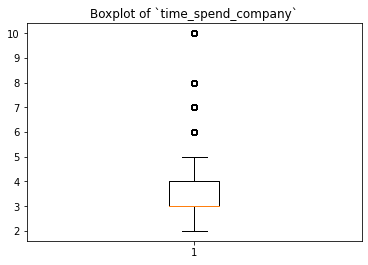

In [19]:
fig, ax = plt.subplots()
ax.set_title('Boxplot of `time_spend_company`')
ax.boxplot(hr_df["time_spend_company"])
plt.show()

We don't want these extreme cases to affect or bias the training process, so the best is to remove them.
We can apply some metric (i.e., the Z-score) to detect and remove these points. Pandas provides a `quantile` function to compute the different quantiles and to remove the outliers based on them:

In [20]:
# See https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
    
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25) 
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

In [21]:
hr_df = remove_outlier(hr_df,'time_spend_company')

1282 outliers removed


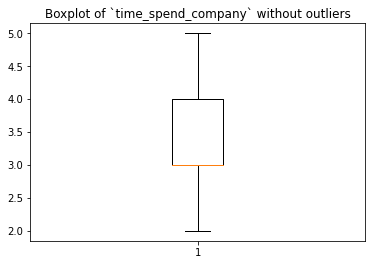

In [22]:
fig, ax = plt.subplots()
ax.set_title('Boxplot of `time_spend_company` without outliers')
ax.boxplot(hr_df["time_spend_company"])
plt.show()

Let's do the same for the rest of the columns with numeric values!

In [23]:
# first we filter according to type: integer or float
numeric_features = [feature for feature in hr_df.columns if hr_df[feature].dtype in ["float64", "int64"]]

for i, feature in enumerate(numeric_features):
    print(f"Analyzing outliers of column: {feature}")
    hr_df = remove_outlier(hr_df, feature)

Analyzing outliers of column: satisfaction_level
0 outliers removed
Analyzing outliers of column: last_evaluation
0 outliers removed
Analyzing outliers of column: number_project
0 outliers removed
Analyzing outliers of column: average_montly_hours
0 outliers removed
Analyzing outliers of column: time_spend_company
0 outliers removed
Analyzing outliers of column: satisfaction_level_bin
0 outliers removed
Analyzing outliers of column: last_evaluation_bin
3540 outliers removed


### 4.5. One hot encoding

As we have some categorical values with strings, we need to encode them for the application of the sklearn classifiers: One-hot encoding!
    
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [24]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = hr_df.columns[hr_df.dtypes=='category'].tolist()
categorical_cols.remove('left') # All the categorical features except the target variable

numerical_cols = hr_df.columns[hr_df.dtypes!='category'].tolist()

ohe = OneHotEncoder()

# Concat the numerical and dummified categorical columns
dummified_hr_df = pd.concat(
    # list of dataset to concat
    [ 
        hr_df[numerical_cols].reset_index(drop=True),
        pd.DataFrame(ohe.fit_transform(hr_df[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True),
        hr_df['left'].reset_index(drop=True)
    ], 
    axis=1  # concat side-by_side
)

dummified_hr_df.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,satisfaction_level_bin,last_evaluation_bin,Work_accident_0,Work_accident_1,promotion_last_5years_0,...,salary_high,salary_low,salary_medium,number_project_cat_High,number_project_cat_Low,number_project_cat_Medium,number_project_cat_Very_High,time_spend_company_cat_Low,time_spend_company_cat_Medium,left
0,0.38,0.53,2,157,3,2,2,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
1,0.11,0.88,7,272,4,0,3,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1
2,0.72,0.87,5,223,5,4,3,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,0.37,0.52,2,159,3,2,2,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4,0.41,0.50,2,153,3,2,2,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1


### 4.6. Evolution of data:

Columns and dtypes in the original data: `initial_hr_df`

In [25]:
initial_hr_df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

Columns and dtypes of the data after Feature Engineering: `dummified_hr_df`

In [26]:
dummified_hr_df.dtypes

satisfaction_level                float64
last_evaluation                   float64
number_project                      int64
average_montly_hours                int64
time_spend_company                  int64
satisfaction_level_bin              int64
last_evaluation_bin                 int64
Work_accident_0                   float64
Work_accident_1                   float64
promotion_last_5years_0           float64
promotion_last_5years_1           float64
sales_IT                          float64
sales_RandD                       float64
sales_accounting                  float64
sales_hr                          float64
sales_management                  float64
sales_marketing                   float64
sales_product_mng                 float64
sales_sales                       float64
sales_support                     float64
sales_technical                   float64
salary_high                       float64
salary_low                        float64
salary_medium                     

# 5. Second predictions after feature engineering.

### 5.1. Train-Test Splitting

We are going to split the "feature engineered" dataset in training and test for the later evaluation of our ML models. To that end, sklearn again provides a `train_test_split` function to do it.

The ratio of `test` data to total is 33 %.

The split between `train` and `test` is done randomly, but in order for all of us to receive the same random split we have to set the `random_state` parameter.

In [27]:
from sklearn.model_selection import train_test_split

# left is the target variable
X = dummified_hr_df.drop("left", axis=1)
y = dummified_hr_df['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### 5.2. Training and feature importance

We first fit a linear model to the initial dataset to have a baseline to evaluate the impact of the data cleaning and feature engineering.

To facilitate the training process we will use the `sklearn` library <https://scikit-learn.org/stable/index.html> that provides a wrapper for the preprocessing, training and evaluation of many machine learning algorithms. 

In [28]:
from sklearn import linear_model
fe_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
fe_lm_mod.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='none')

In [29]:
get_feature_importance(fe_lm_mod, X_train.columns)

,variable,coefficient
27,number_project_cat_Very_High,9.470000
1,last_evaluation,3.910000
0,satisfaction_level,3.730000
7,Work_accident_0,1.980000
29,time_spend_company_cat_Medium,1.970000
9,promotion_last_5years_0,1.800000
24,number_project_cat_High,1.490000
22,salary_low,1.460000
23,salary_medium,1.160000
10,promotion_last_5years_1,0.830000


### 5.3 Prediction and Evaluation for the feature-engineered data

In [30]:
y_hat_fe = fe_lm_mod.predict(X_test)

Labels: [1, 0]


,name,accuracy,precision,recall,f1,cohen_kappa,MCC
0,baseline,0.757374,0.482935,0.239627,0.320317,0.192538,0.210080
1,feature_engineered,0.903840,0.800272,0.769935,0.784810,0.722927,0.723151


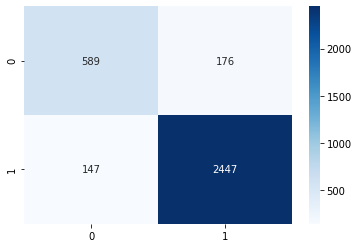

In [31]:
# let's see the labels we are predicting
labels = list(dummified_hr_df["left"].unique())
print(f"Labels: {labels}")

# evaluation metrics
fe_metrics = evaluation_metrics(y_test, y_hat_fe, "feature_engineered")
results["feature_engineering"] = fe_metrics

# confusion matrix
conf_mtx = confusion_matrix(y_test, y_hat_fe, labels=labels)
sns.heatmap(conf_mtx, annot=True, cmap="Blues", fmt="d")

# print metrics
pd.DataFrame(results.values())

### 5.4. Results:
Every metric has improved by performing Feature engineering!

# 6. Feature selection by filtering: Chi-squared and Information Gain

We will rank the features according to their predictive power by applying the following methodologies: 
* Chi Squared Independence test 
* Information Gain.

### 6.1. Feature selection
Making use of the `SelectKBest` function rank the features according to the Chi Squared and Information Gain scores. 

Does it make sense to remove some features? If so, do it!

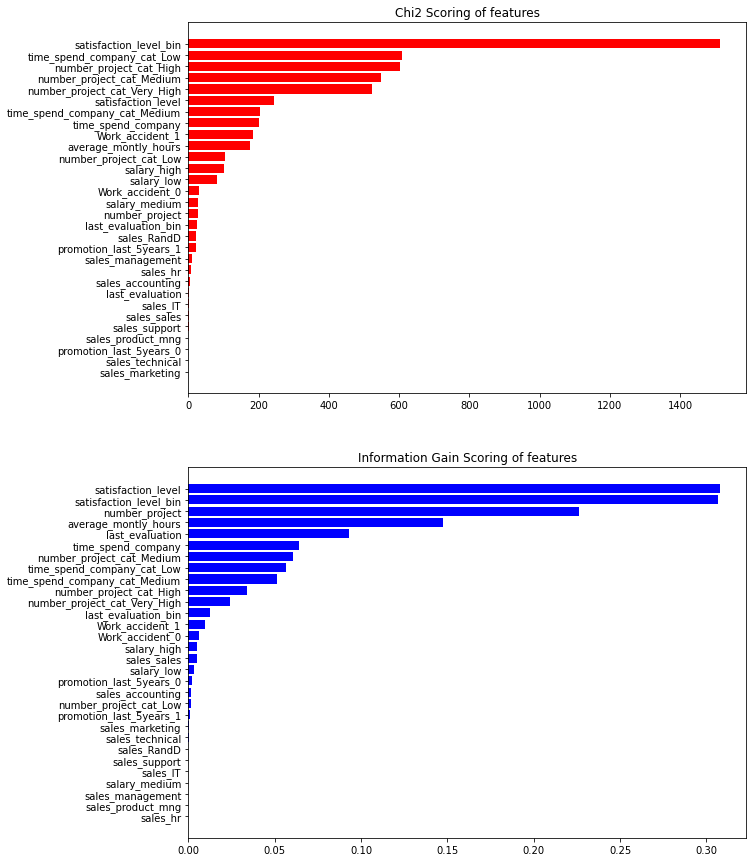

In [32]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Select K best features according to the two different methods
chi2_selector = SelectKBest(score_func=chi2).fit(X,y)  # using Chi-squared
ig_selector = SelectKBest(score_func=mutual_info_classif).fit(X,y)  # using Information Gain

# Get the indices sorted by most important to least important
indices_chi2 = np.argsort(chi2_selector.scores_)[::-1]
indices_ig = np.argsort(ig_selector.scores_)[::-1]

# Features and their score on each method
chi2_features = []
for i in range(len(X.columns)):
    chi2_features.append(X.columns[indices_chi2[i]])
    
ig_features = []
for i in range(len(X.columns)):
    ig_features.append(X.columns[indices_ig[i]])
    
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# chi2 scores
axes[0].invert_yaxis()
axes[0].barh(chi2_features, chi2_selector.scores_[indices_chi2[range(len(X.columns))]], color='r', align='center')
axes[0].set_title("Chi2 Scoring of features")

# information-gain scores
axes[1].invert_yaxis()
axes[1].barh(ig_features, ig_selector.scores_[indices_ig[range(len(X.columns))]], color='b', align='center')
axes[1].set_title("Information Gain Scoring of features")

plt.show()

### 6.3. How many features to keep in each case?

Should we keep all the features in our model? Let's see how the accuracy changes when including them...

In [ ]:
classifier = linear_model.LogisticRegression(max_iter=1020, penalty='none')

methods = {
    "chi2": chi2_features,
    "ig": ig_features
}

comparison = []
for name, sorted_features in methods.items():
    features_used = 0
    for i, feature in enumerate(sorted_features):

        # training on a bigger subset of features as we loop through `chi2_features`
        # as i increases, a new feature is added to the training dataset
        # since the features were sorted in descending order of score, each added feature will add less value to our prediction
        X_train_subset = X_train[sorted_features[: i+1]]
        X_test_subset = X_test[sorted_features[: i+1]]

        # train
        classifier.fit(X_train_subset, y_train)

        # predict
        y_hat_subset = classifier.predict(X_test_subset)

        # calculate accuracy
        acc = accuracy_score(y_test, y_hat_subset)

        # increase counter to see how many features we have trained with
        features_used += 1
        dict_sorted = {
            "features": features_used,
            "accuracy": acc,
            "type": name
        }
        comparison.append(dict_sorted)
        
# put everything together in a dataframe
comparison_df = pd.DataFrame(comparison)

In [ ]:
comparison_df.head()

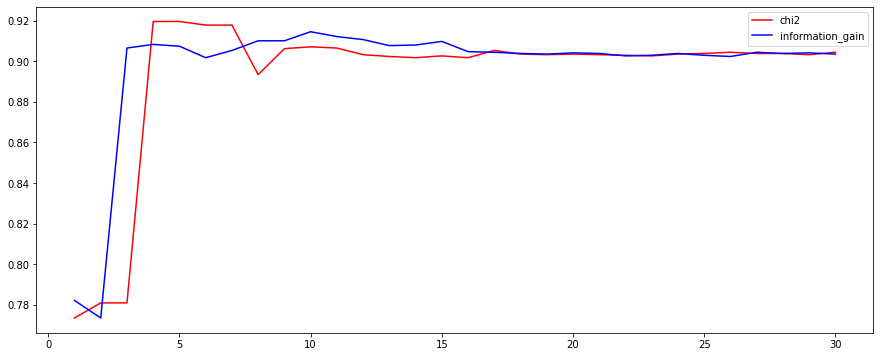

In [55]:
chi2_evolution = comparison_df[comparison_df["type"]=="chi2"]
ig_evolution = comparison_df[comparison_df["type"]=="ig"]

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(chi2_evolution["features"], chi2_evolution["accuracy"], color="red", label="chi2")
ax.plot(ig_evolution["features"], ig_evolution["accuracy"], color="blue", label="information_gain")
ax.legend()

plt.show()

The sweet spot is around the 5 top features in each case, so lets see their performances and compare with the previous ones!

### 6.3. Training with only some pre-selected features!

In [36]:
features_to_use = 5

# preparing subsets
X_train_chi2 = X_train[chi2_features[:features_to_use]]
X_test_chi2 = X_test[chi2_features[:features_to_use]]

X_train_ig = X_train[ig_features[:features_to_use]]
X_test_ig = X_test[ig_features[:features_to_use]]

In [37]:
# training classifiers
chi2_top5 = linear_model.LogisticRegression(max_iter=1000, penalty='none')
chi2_top5.fit(X_train_chi2, y_train)
y_hat_chi2_top5 = chi2_top5.predict(X_test_chi2)

ig_top5 = linear_model.LogisticRegression(max_iter=1000, penalty='none')
ig_top5.fit(X_train_ig, y_train)
y_hat_ig_top5 = ig_top5.predict(X_test_ig)

In [38]:
# let's see the labels we are predicting
labels = list(y_train.unique())

# evaluation metrics
chi2_top5_metrics = evaluation_metrics(y_test, y_hat_chi2_top5, "chi2_top5")
results["chi2_top5"] = chi2_top5_metrics

ig_top5_metrics = evaluation_metrics(y_test, y_hat_ig_top5, "ig_top5")
results["ig_top5"] = ig_top5_metrics

# print metrics
pd.DataFrame(results.values())

,name,accuracy,precision,recall,f1,cohen_kappa,MCC
0,baseline,0.757374,0.482935,0.239627,0.320317,0.192538,0.210080
1,feature_engineered,0.903840,0.800272,0.769935,0.784810,0.722927,0.723151
2,chi2_top5,0.919619,0.829561,0.814379,0.821900,0.770002,0.770057
3,ig_top5,0.907413,0.785176,0.816993,0.800769,0.740493,0.740741


Performance keeps increasing!! 

# 7. Feature selection: Embedded methods (Ridge, Lasso)

Finally, we will experiment with embedded methods. Going back to the first class, we learned how to optimize our evaluation using RSS (residual sum of squares)

<img src="rss.png" style="width: 300px;">

Embedded methods show another way of feature selection called regularization, in which we will add a "penalty" to our features, reducing or even eliminating their contribution to the global learning.

This methods learn which feature is not adding accuracy while the training stage takes place.

More info: https://scikit-learn.org/stable/modules/linear_model.html

### 7.1. Ridge

`Ridge` is a regularization method that adds a penalty term (type `l2`) to reduce the effect of the features (`x_i`).

Depending on the value of `lambda` we can reduce each feature a lot but never eliminate it.

<img src="rss_ridge.png" style="width: 400px;">

For this exercise, we are going to make use of the Ridge Model in sklearn

In [41]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000, penalty='l2')
ridge_mod.fit(X_train, y_train)
get_feature_importance(ridge_mod, X_train.columns)

,variable,coefficient
27,number_project_cat_Very_High,5.050000
1,last_evaluation,2.370000
0,satisfaction_level,2.270000
24,number_project_cat_High,1.450000
4,time_spend_company,0.750000
29,time_spend_company_cat_Medium,0.710000
7,Work_accident_0,0.700000
22,salary_low,0.600000
9,promotion_last_5years_0,0.490000
16,sales_marketing,0.310000


Labels: [1, 0]


,name,accuracy,precision,recall,f1,cohen_kappa,MCC
0,baseline,0.757374,0.482935,0.239627,0.320317,0.192538,0.210080
1,feature_engineered,0.903840,0.800272,0.769935,0.784810,0.722927,0.723151
2,chi2_top5,0.919619,0.829561,0.814379,0.821900,0.770002,0.770057
3,ig_top5,0.907413,0.785176,0.816993,0.800769,0.740493,0.740741
4,Ridge,0.905031,0.804645,0.769935,0.786907,0.725846,0.726138


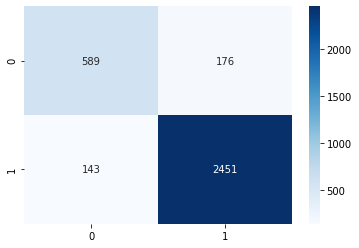

In [42]:
y_hat_ridge = ridge_mod.predict(X_test)

# let's see the labels we are predicting
labels = list(dummified_hr_df["left"].unique())
print(f"Labels: {labels}")

# evaluation metrics
ridge_metrics = evaluation_metrics(y_test, y_hat_ridge, "Ridge")
results["ridge"] = ridge_metrics

# confusion matrix
conf_mtx = confusion_matrix(y_test, y_hat_ridge, labels=labels)
sns.heatmap(conf_mtx, annot=True, cmap="Blues", fmt="d")

# print metrics
pd.DataFrame(results.values())

### 7.2. Lasso

`Lasso` is a regularization method that adds a penalty term (type `l1`) to eliminate the effect of some of the features (`x_i`).

Depending on the value of `lambda` we can reduce and even eliminate the contribution of some features.

<img src="rss_lasso.png" style="width: 400px;">

In [43]:
lasso_mod = linear_model.LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')  # for handling l1 regularization we need to use another solver method
lasso_mod.fit(X_train, y_train)
get_feature_importance(lasso_mod, X_train.columns)

,variable,coefficient
27,number_project_cat_Very_High,10.100000
24,number_project_cat_High,4.460000
1,last_evaluation,3.150000
0,satisfaction_level,2.900000
7,Work_accident_0,1.340000
22,salary_low,1.330000
29,time_spend_company_cat_Medium,1.330000
9,promotion_last_5years_0,1.110000
23,salary_medium,1.020000
4,time_spend_company,0.770000


Labels: [1, 0]


,name,accuracy,precision,recall,f1,cohen_kappa,MCC
0,baseline,0.757374,0.482935,0.239627,0.320317,0.192538,0.210080
1,feature_engineered,0.903840,0.800272,0.769935,0.784810,0.722927,0.723151
2,chi2_top5,0.919619,0.829561,0.814379,0.821900,0.770002,0.770057
3,ig_top5,0.907413,0.785176,0.816993,0.800769,0.740493,0.740741
4,Ridge,0.905031,0.804645,0.769935,0.786907,0.725846,0.726138
5,Lasso,0.905329,0.806584,0.768627,0.787149,0.726321,0.726670


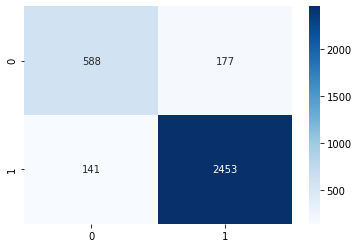

In [44]:
y_hat_lasso = lasso_mod.predict(X_test)

# let's see the labels we are predicting
labels = list(dummified_hr_df["left"].unique())
print(f"Labels: {labels}")

# evaluation metrics
lasso_metrics = evaluation_metrics(y_test, y_hat_lasso, "Lasso")
results["lasso"] = lasso_metrics

# confusion matrix
conf_mtx = confusion_matrix(y_test, y_hat_lasso, labels=labels)
sns.heatmap(conf_mtx, annot=True, cmap="Blues", fmt="d")

# print metrics
pd.DataFrame(results.values())